# Adding texture to heightmaps

Unlike meshes, heightmap textures are described as a set of textures, each texture configured to be rendered at a height interval of the heightmap and blended together with the neighbouring textures in order to have seamless transitions from one textures to another.

In [1]:
import trimesh
from skimage.draw import random_shapes
from pcg_gazebo.generators import HeightmapGenerator
from pcg_gazebo.generators.biomes import Biome, WhittakerBiome

# Create a heightmap generator
hg = HeightmapGenerator(
    map_size=[200, 200, 120])

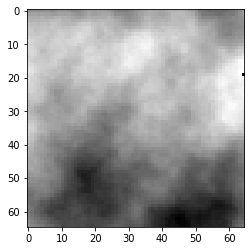

In [2]:
# Let's create a heightmap from Perlin noise function
hg.add_perlin_noise_layer(freq=10.0, octaves=10)
hg.show()

In [3]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

/home/mam0box/Software/devel/pcg_gazebo/venv/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:


In [4]:
# Now store this heightmap
model = hg.as_model()

model.name = 'pcg_no_texture_perlin_heighmap'
model_path = model.to_gazebo_model(copy_resources=True, overwrite=True)

2020-07-10 17:23:39,706 | WARNING | model | Another model <pcg_no_texture_perlin_heighmap> was found at /home/mam0box/.gazebo/models/pcg_no_texture_perlin_heighmap


Lossy conversion from float64 to uint8. Range [0.0, 252.0]. Convert image to uint8 prior to saving to suppress this warning.


In [5]:
# Preview of the current SDF without any textures
print(model.to_sdf())

2020-07-10 17:23:39,750 | WARNING | heightmap | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
2020-07-10 17:23:39,755 | WARNING | heightmap | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
<model name="pcg_no_texture_perlin_heighmap">
  <pose frame="">0 0 0 0 -0 0</pose>
  <static>0</static>
  <self_collide>0</self_collide>
  <allow_auto_disable>0</allow_auto_disable>
  <link name="link">
    <kinematic>0</kinematic>
    <gravity>1</gravity>
    <self_collide>0</self_collide>
    <collision name="collision">
      <geometry>
        <heightmap>
          <uri>model://pcg_no_texture_perlin_heighmap/materials/textures/heightmap.png</uri>
          <size>200 200 120</size>
          <pos>0 0 0</pos>
          <use_terrain_paging>0</use_terrain_paging>
          <sampling>2</sampling>
        </heightmap>
      </geometry>
      <pose frame="">0 0 0 0 -0 0</pose>
    </col

The exported model can now be found in the list of models available in the Gazebo simulator with the name `pcg_no_texture_perlin_heightmap`.

![heightmap_without_texture](images/heightmap_without_texture.png)

## Create a biome to set the heightmap texture

To set the set of textures for a heightmap, there needs to be `n` [`<texture>`](http://sdformat.org/spec?ver=1.7&elem=geometry#heightmap_texture) images and `n - 1` [`<blend>`](http://sdformat.org/spec?ver=1.7&elem=geometry#heightmap_blend) elements describing at which height the texture will appear.

In the example below, a simple set of textures is created using the `Biome`.
The implementation of this `Biome` class is based on this [source](http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/), where the biomes are classified according to moisture and elevation zones.

For the generation of the final set of textures, a moisture zone is set and the elevation zones will defined the input for the `<blend>` objets.

In [6]:
# Creating a biome from flat colors
biome = Biome(n_moisture_zones=1, n_elevation_zones=3)

biome.add_biome('bottom', color=[203, 65, 107])
biome.add_biome('middle', color=[6, 154, 243])
biome.add_biome('top', color=[31, 167, 116])

biome.add_rule(biome='bottom', moisture_zone=0, elevation_zone=0)
biome.add_rule(biome='middle', moisture_zone=0, elevation_zone=1)
biome.add_rule(biome='top', moisture_zone=0, elevation_zone=2)

# The first blending of textures happends after the first layer ("bottom" biome)
biome.set_min_height(height=40.0, elevation_zone=1)
biome.set_fade_dist(fade_dist=1, elevation_zone=1)

biome.set_min_height(height=80.0, elevation_zone=2)
biome.set_fade_dist(fade_dist=1, elevation_zone=2)

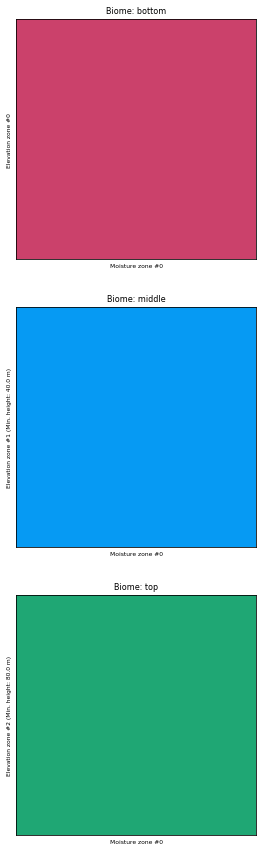

In [7]:
fig = biome.show()

In [8]:
hg.biome = biome

In [9]:
# Now store this heightmap
model = hg.as_model()

model.name = 'pcg_perlin_heighmap_custom_biome'
model_path = model.to_gazebo_model(copy_resources=True, overwrite=True)

2020-07-10 17:23:40,353 | WARNING | model | Another model <pcg_perlin_heighmap_custom_biome> was found at /home/mam0box/.gazebo/models/pcg_perlin_heighmap_custom_biome


In [10]:
# Preview of the current SDF without any textures
print(model.to_sdf())

2020-07-10 17:23:40,464 | WARNING | heightmap | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
2020-07-10 17:23:40,468 | WARNING | heightmap | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
2020-07-10 17:23:40,471 | WARNING | texture | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
2020-07-10 17:23:40,474 | WARNING | texture | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
2020-07-10 17:23:40,477 | WARNING | texture | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
<model name="pcg_perlin_heighmap_custom_biome">
  <pose frame="">0 0 0 0 -0 0</pose>
  <static>0</static>
  <self_collide>0</self_collide>
  <allow_auto_disable>0</allow_auto_disable>
  <link name="link">
    <kinematic>0</kinematic>
  

Now the model is available in the model list that can be added in the Gazebo simulator.

![custom_biome](images/custom_biome.png)

## Whittaker biome

In [11]:
biome = WhittakerBiome()

# Adjust the blending elements to the range of the heightmap
biome.set_min_height(100.0, 3)
biome.set_fade_dist(5, 3)
biome.set_min_height(80.0, 2)
biome.set_fade_dist(5, 2)
biome.set_min_height(40.0, 1)
biome.set_fade_dist(5, 1)

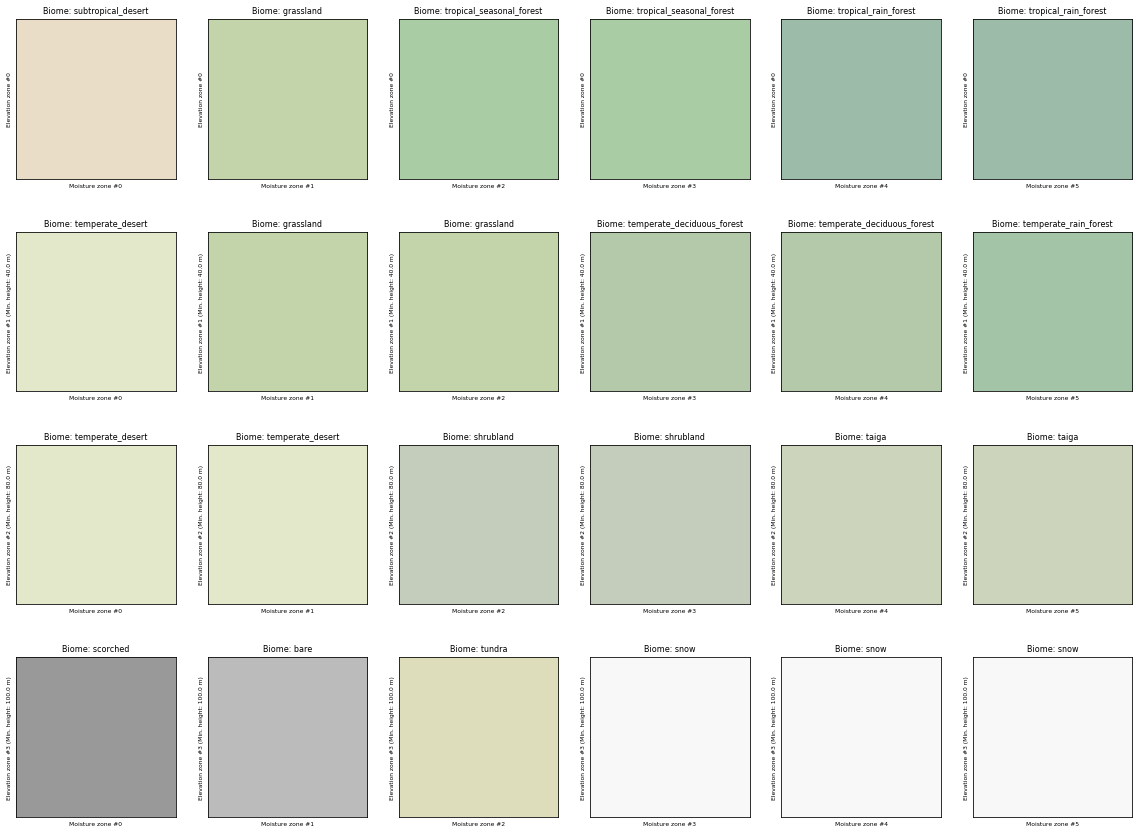

In [12]:
fig = biome.show()

In [13]:
# Set the Whittaker biome
hg.biome = biome

# Export models for each moisture zone
for n in range(biome.n_moisture_zones):
    hg.biome.moisture_zone = n
    # Now store this heightmap
    model = hg.as_model()

    model.name = 'pcg_perlin_heighmap_whittaker_biome_moisture_zone_{}'.format(n)
    model_path = model.to_gazebo_model(copy_resources=True, overwrite=True)
    print('Model stored: {}'.format(model_path))

2020-07-10 17:23:44,788 | WARNING | model | Another model <pcg_perlin_heighmap_whittaker_biome_moisture_zone_0> was found at /home/mam0box/.gazebo/models/pcg_perlin_heighmap_whittaker_biome_moisture_zone_0
Model stored: /home/mam0box/.gazebo/models/pcg_perlin_heighmap_whittaker_biome_moisture_zone_0
2020-07-10 17:23:44,917 | WARNING | model | Another model <pcg_perlin_heighmap_whittaker_biome_moisture_zone_1> was found at /home/mam0box/.gazebo/models/pcg_perlin_heighmap_whittaker_biome_moisture_zone_1
Model stored: /home/mam0box/.gazebo/models/pcg_perlin_heighmap_whittaker_biome_moisture_zone_1
2020-07-10 17:23:45,027 | WARNING | model | Another model <pcg_perlin_heighmap_whittaker_biome_moisture_zone_2> was found at /home/mam0box/.gazebo/models/pcg_perlin_heighmap_whittaker_biome_moisture_zone_2
Model stored: /home/mam0box/.gazebo/models/pcg_perlin_heighmap_whittaker_biome_moisture_zone_2
2020-07-10 17:23:45,132 | WARNING | model | Another model <pcg_perlin_heighmap_whittaker_biome_mo

**Heightmap - Moisture zone #0**

![heightmap_whittaker_moisture_0](images/heightmap_whittaker_moisture_0.png)

**Heightmap - Moisture zone #1**

![heightmap_whittaker_moisture_1](images/heightmap_whittaker_moisture_1.png)

**Heightmap - Moisture zone #2**

![heightmap_whittaker_moisture_2](images/heightmap_whittaker_moisture_2.png)

**Heightmap - Moisture zone #3**

![heightmap_whittaker_moisture_3](images/heightmap_whittaker_moisture_3.png)

**Heightmap - Moisture zone #4**

![heightmap_whittaker_moisture_4](images/heightmap_whittaker_moisture_4.png)

**Heightmap - Moisture zone #5**

![heightmap_whittaker_moisture_5](images/heightmap_whittaker_moisture_5.png)